# Getting ready for manual annotation on MIMIC-CXR dataset

There are 227835 reports in the dataset, each report has multiple section, such as findings and imporession.

1. Balanced sampling:  The anatomy and observation could be quite different. We don't want to sample on the same anatomy and observation.
   1. To do so, we can statistic on which anatomy appears how many times on which report.
2. 

## Preparing

In [1]:
import sys
sys.path.append("../../src")

import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from concurrent.futures import ProcessPoolExecutor, as_completed
from multiprocessing import Event
from common_utils.data_loader_utils import load_mimic_cxr_bySection
from common_utils.coref_utils import resolve_mention_and_group_num
from common_utils.file_checker import FileChecker
from common_utils.common_utils import check_and_create_dirs

FILE_CHECKER = FileChecker()
START_EVENT = Event()

mpl.style.use("default")

In [2]:
from hydra import compose, initialize
from omegaconf import OmegaConf

config = None
with initialize(version_base=None, config_path="../config", job_name="nlp_ensemble"):
        config = compose(config_name="data_preprocessing", overrides=["+nlp_ensemble@_global_=mimic_cxr"])
        section_name_cfg = config.name_style.mimic_cxr.section_name
        output_section_cfg = config.output.section
        input_path = config.input.path
        data_size, pid_list, sid_list, section_list = load_mimic_cxr_bySection(input_path, output_section_cfg, section_name_cfg)

# Sort
s_list, f_list, i_list, pfi_list, fai_list = zip(*sorted(zip(sid_list, section_list[0][1], section_list[1][1], section_list[2][1], section_list[3][1])))
sid_list = s_list
section_list = [
        ("findings", f_list),
        ("impression", i_list),
        ("provisional_findings_impression", pfi_list),
        ("findings_and_impression",fai_list)
]


In [3]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Word frequency

In [4]:
from collections import Counter

def batch_processing(sid, input_path):
    START_EVENT.wait()
    df_spacy = pd.read_csv(input_path, index_col=0, na_filter=False)

    word_counter = Counter()
    word_counter.update(df_spacy.loc[:,"[sp]token"].to_list())

    return sid, word_counter


for section_entry in os.scandir("../../output/mimic_cxr/nlp_ensemble/spacy"):
    if section_entry.is_dir():
        total_word_counter = Counter()
        
        tasks = []
        with ProcessPoolExecutor(max_workers=14) as executor:
            for report_entry in tqdm(os.scandir(section_entry.path)):
                if FILE_CHECKER.ignore(os.path.abspath(report_entry.path)):
                    continue
                sid = report_entry.name.rstrip(".csv")
                tasks.append(executor.submit(batch_processing, sid, report_entry.path))

            START_EVENT.set()

            # Receive results from multiprocessing.
            for future in tqdm(as_completed(tasks), total=len(tasks)):
                sid, word_counter = future.result()
                total_word_counter.update(word_counter)

            START_EVENT.clear()
        
        print("Section:", section_entry.name)
        print(total_word_counter.most_common(100))
        print("-" * 80)

10589it [00:00, 16533.53it/s]
100%|██████████| 10589/10589 [00:02<00:00, 4679.30it/s]


Section: findings_and_impression
[('.', 54772), (' ', 37886), ('is', 32938), ('the', 27505), (',', 14683), ('of', 13821), ('in', 13161), ('are', 12797), ('There', 10375), ('and', 9888), ('right', 8940), ('_', 8394), ('The', 7887), ('pleural', 7598), ('left', 7257), ('pneumothorax', 6891), ('effusion', 6618), ('no', 6581), ('unchanged', 6277), ('to', 6178), ('tip', 6116), ('with', 5734), ('tube', 5239), ('-', 4346), ('size', 4286), ('lung', 4143), ('atelectasis', 4128), ('lower', 4103), ('be', 3902), ('or', 3806), ('lobe', 3614), ('at', 3521), ('on', 3475), ('No', 3316), ('pulmonary', 3140), ('seen', 3105), ('prior', 3086), ('stable', 3045), ('has', 3017), ('edema', 2826), ('interval', 2815), ('mediastinum', 2792), ('Heart', 2791), ('Right', 2652), ('opacities', 2503), ('normal', 2433), ('as', 2406), ('study', 2357), ('a', 2336), ('\n', 2206), ('clear', 2174), ('chest', 2165), ('position', 2143), ('upper', 2142), ('effusions', 2052), ('likely', 2039), ('SVC', 2016), ('Left', 1991), ('sm

189465it [00:08, 22132.64it/s]
100%|██████████| 189465/189465 [00:48<00:00, 3911.52it/s]


Section: impression
[('.', 534768), ('the', 232939), (' ', 215151), ('_', 193488), ('of', 149166), (',', 148245), ('is', 124640), ('No', 115083), ('in', 92675), ('and', 90755), ('right', 78457), ('to', 77177), ('pleural', 68459), ('left', 64311), ('with', 61047), ('acute', 57522), ('pulmonary', 51395), ('are', 45539), ('lung', 45279), ('effusion', 44602), ('atelectasis', 40254), ('edema', 39659), ('process', 39588), ('pneumonia', 39506), ('cardiopulmonary', 38931), ('pneumothorax', 36036), ('\n ', 35695), ('tube', 34761), ('or', 34325), ('no', 33715), ('chest', 33432), ('a', 31902), ('be', 30700), ('at', 30048), ('-', 27320), ('evidence', 27276), ('lower', 27115), ('The', 26734), ('There', 25853), ('has', 25788), ('on', 25180), ('effusions', 22982), ('lobe', 22743), ('unchanged', 22177), ('size', 20303), ('for', 20119), ('there', 19417), ('small', 19229), ('compared', 19063), ('1', 18901), ('2', 17792), ('not', 17328), ('study', 17065), ('cardiomegaly', 16700), ('opacity', 16492), ('ch

201it [00:00, 1072.66it/s]
100%|██████████| 200/200 [00:00<00:00, 3954.48it/s]


Section: provisional_findings_impression
[('_', 1973), ('.', 871), (' ', 368), ('the', 141), ('PM', 136), ('of', 131), (':', 121), (',', 120), ('1', 102), ('and', 102), ('pleural', 101), ('right', 90), ('2', 83), ('with', 81), ('left', 80), ('AM', 80), ('atelectasis', 68), ('effusion', 67), ('\n ', 64), ('No', 63), ('pneumonia', 62), ('PFI', 62), ('pulmonary', 60), ('in', 59), ('to', 53), ('small', 45), ('edema', 43), ('IMPRESSION', 43), ('are', 42), ('evidence', 41), ('lung', 41), ('is', 39), ('-', 37), ('or', 37), ('pneumothorax', 36), ('acute', 35), ('no', 34), ('process', 33), ('The', 33), ('3', 32), ('lobe', 31), (';', 31), ('tube', 30), ('Stable', 29), ('moderate', 29), ('bilateral', 28), ('effusions', 27), ('lower', 27), ('be', 27), ('chest', 24), ('for', 24), ('from', 23), ('radiograph', 23), ('mild', 22), ('mediastinal', 22), ('VERSION', 22), ('#', 22), ('on', 21), ('may', 20), ('cardiomegaly', 20), ('cardiopulmonary', 19), ('heart', 19), ('a', 19), ('normal', 18), ('unchanged

156011it [00:07, 20635.33it/s]
100%|██████████| 156011/156011 [00:43<00:00, 3617.36it/s]


Section: findings
[('.', 831223), (' ', 498804), ('is', 390873), ('the', 367445), (',', 223458), ('are', 210356), ('of', 197024), ('and', 184697), ('The', 178137), ('There', 134410), ('pleural', 123680), ('in', 116108), ('right', 114073), ('effusion', 112844), ('pneumothorax', 110557), ('No', 106162), ('_', 104467), ('or', 101617), ('no', 96033), ('normal', 90172), ('left', 85906), ('with', 81368), ('to', 77965), ('seen', 66982), ('lung', 65939), ('pulmonary', 59399), ('chest', 59312), ('consolidation', 56287), ('clear', 54078), ('-', 53930), ('silhouette', 52868), ('a', 50802), ('contours', 48968), ('focal', 48835), ('unchanged', 48825), ('lungs', 46920), ('size', 46635), ('atelectasis', 43314), ('mediastinal', 41555), ('hilar', 38467), ('edema', 38235), ('lateral', 37732), ('tube', 34096), ('prior', 32751), ('on', 32407), ('at', 32323), ('cardiac', 31411), ('cardiomediastinal', 30547), ('noted', 29061), ('within', 28452), ('lower', 28191), ('has', 27936), ('heart', 27407), ('stable',

## The scatter plot of "number of tokens" and "number of coreference" per document

In [5]:
from collections import Counter

scoref_dir = "../../output/mimic_cxr/nlp_ensemble/corenlp/scoref"
dcoref_dir = "../../output/mimic_cxr/nlp_ensemble/corenlp/dcoref"
fcoref_dir = "../../output/mimic_cxr/nlp_ensemble/fast_coref_joint"

def batch_processing(section_name, sid, spacy_input_path):
    START_EVENT.wait()
    df_spacy = pd.read_csv(spacy_input_path, index_col=0, na_filter=False)
    df_scoref = pd.read_csv(os.path.join(scoref_dir,section_name,sid+".csv"), index_col=0, na_filter=False)
    df_dcoref = pd.read_csv(os.path.join(dcoref_dir,section_name,sid+".csv"), index_col=0, na_filter=False)
    df_fcoref = pd.read_csv(os.path.join(fcoref_dir,section_name,sid+".csv"), index_col=0, na_filter=False)

    token_list = df_spacy.loc[:,"[sp]token"].to_list()
    token_num = len(token_list)

    _, scoref_group_num = resolve_mention_and_group_num(df_scoref, "[co][ml]coref_group_conll")
    _, dcoref_group_num = resolve_mention_and_group_num(df_dcoref, "[co][rb]coref_group_conll")
    _, fcoref_group_num = resolve_mention_and_group_num(df_fcoref, "[fj]coref_group_conll")

    return sid, token_num, scoref_group_num, dcoref_group_num, fcoref_group_num

section_doc_numData_dict:dict[str,dict[str,dict[str,int]]] = {}
section_scatter_data_list = {}
for section_entry in os.scandir("../../output/mimic_cxr/nlp_ensemble/spacy"):
    if section_entry.is_dir():
        print("Processing section:", section_entry.name)
        section_doc_numData_dict[section_entry.name]:dict[str,dict[str,int]] = {}

        tasks = []
        scatter_data_list:list[dict] = []
        with ProcessPoolExecutor(max_workers=14) as executor:
            for report_entry in tqdm(os.scandir(section_entry.path)):
                if FILE_CHECKER.ignore(os.path.abspath(report_entry.path)):
                    continue
                sid = report_entry.name.rstrip(".csv")
                tasks.append(executor.submit(batch_processing,section_entry.name, sid, report_entry.path))

            START_EVENT.set()

            # Receive results from multiprocessing.
            for future in tqdm(as_completed(tasks), total=len(tasks)):
                sid, token_num, scoref_group_num, dcoref_group_num, fcoref_group_num = future.result()
                numData = {
                    "tokNum":token_num,
                    "sNum": scoref_group_num,
                    "dNum": dcoref_group_num,
                    "fNum": fcoref_group_num,
                    "avgNum": (scoref_group_num + dcoref_group_num + fcoref_group_num) / 3
                }
                # For later statistic
                section_doc_numData_dict[section_entry.name][sid]:dict[str,int] = numData
                # For scatter plot
                scatter_data_list.append(numData)

            START_EVENT.clear()

        section_scatter_data_list[section_entry.name] = scatter_data_list

Processing section: findings_and_impression


10589it [00:00, 16291.13it/s]
100%|██████████| 10589/10589 [00:11<00:00, 936.84it/s]


Processing section: impression


189465it [00:09, 20432.71it/s]
100%|██████████| 189465/189465 [03:03<00:00, 1030.11it/s]


Processing section: provisional_findings_impression


201it [00:00, 805.41it/s]
100%|██████████| 200/200 [00:00<00:00, 915.14it/s]


Processing section: findings


156011it [00:07, 19977.06it/s]
100%|██████████| 156011/156011 [02:44<00:00, 946.19it/s]


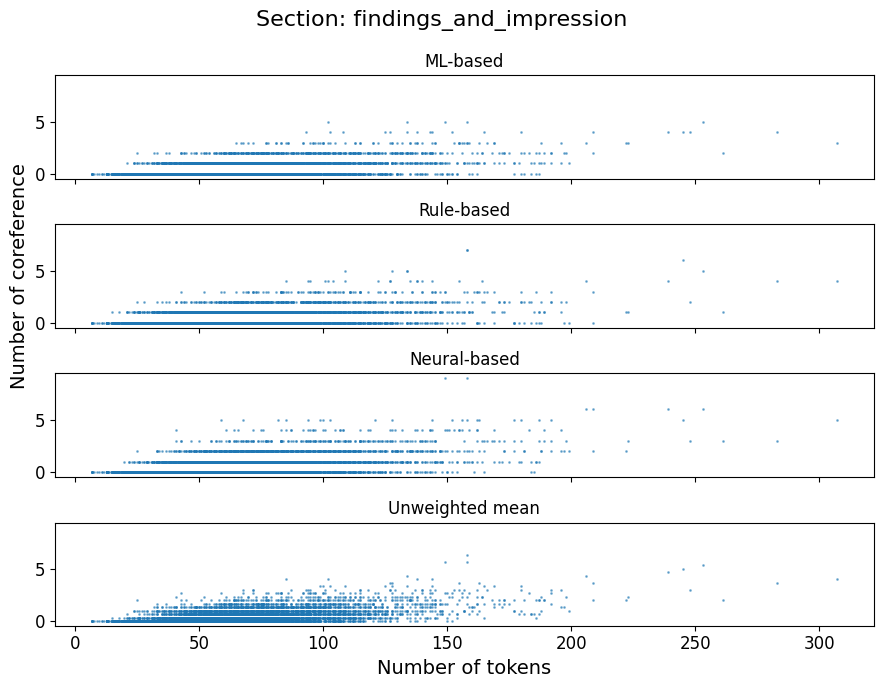

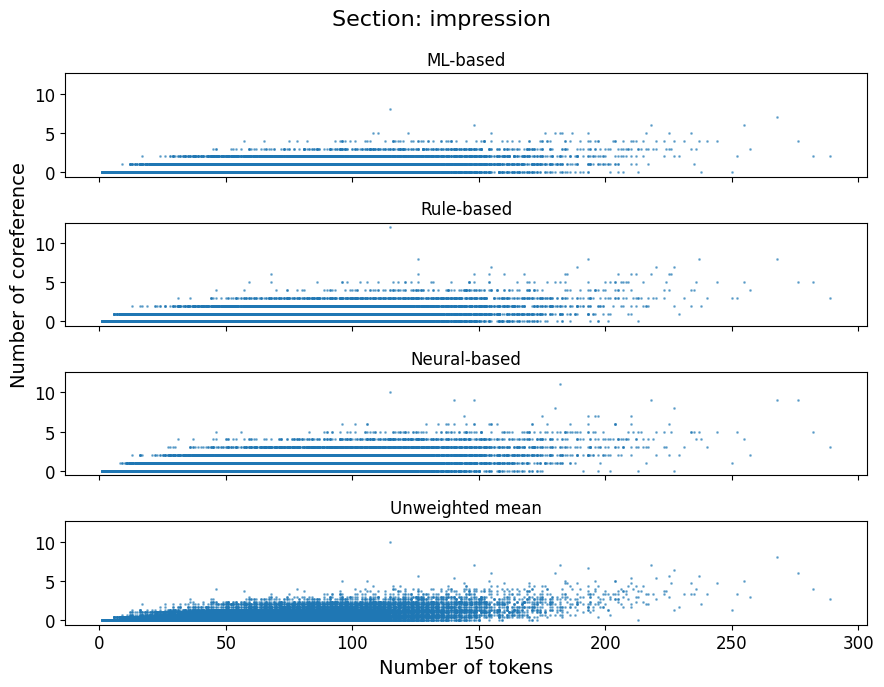

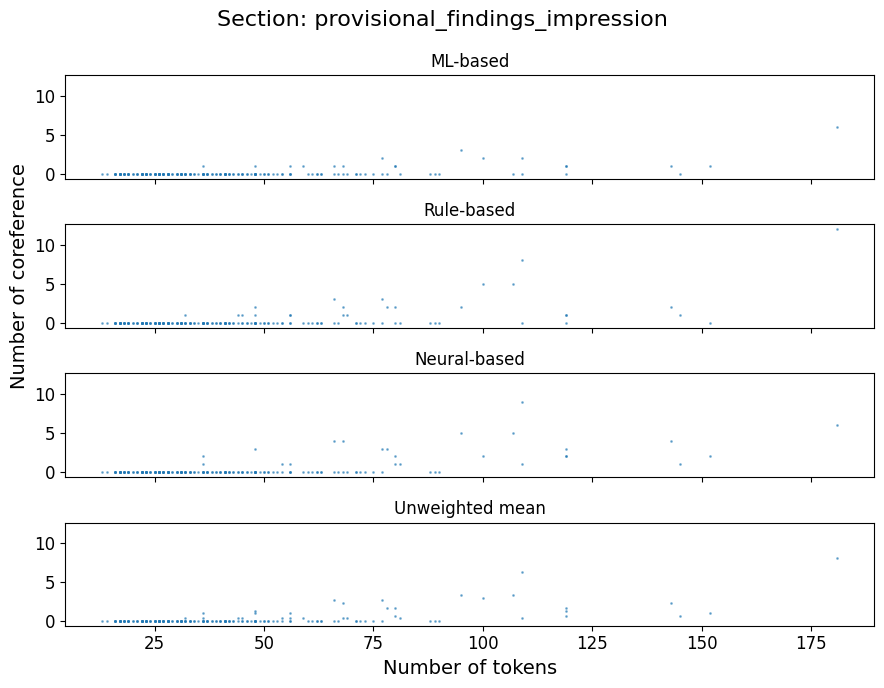

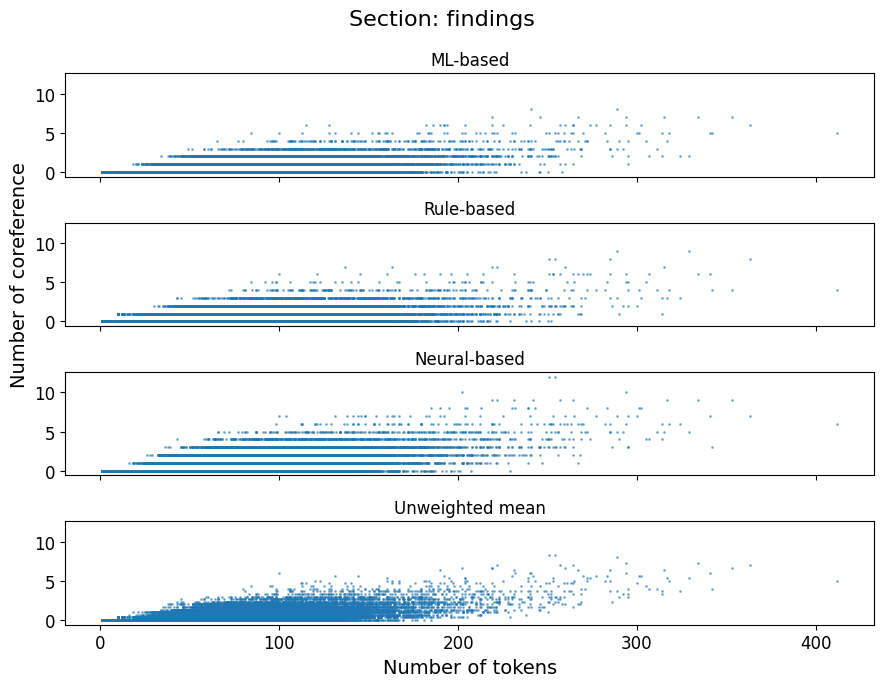

In [6]:
for section_name, scatter_data_list in section_scatter_data_list.items():

    scatter_data_list = sorted(scatter_data_list, key=lambda x: x["tokNum"]) # Sort by token num

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(9,7))
    fig.suptitle(f"Section: {section_name}")
    fig.tight_layout()

    ax1.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["sNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)
    ax2.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["dNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)
    ax3.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["fNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)
    ax4.scatter([data_dict["tokNum"] for data_dict in scatter_data_list], [data_dict["avgNum"] for data_dict in scatter_data_list],s=1, alpha=0.5)

    ax1.set_title("ML-based")
    ax2.set_title("Rule-based")
    ax3.set_title("Neural-based")
    ax4.set_title("Unweighted mean")
    ax2.set_ylabel("Number of coreference", fontdict={"size":14})
    ax4.set_xlabel("Number of tokens", fontdict={"size":14})
    fig.tight_layout()
            

## The Bar charts of "number of coreference on average in the scale of token numbers" for each section

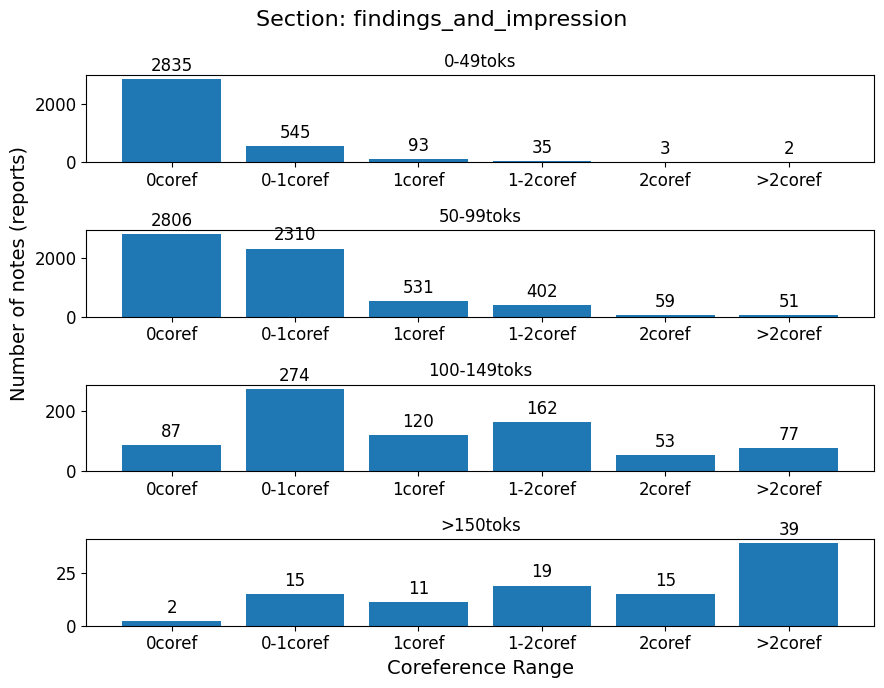

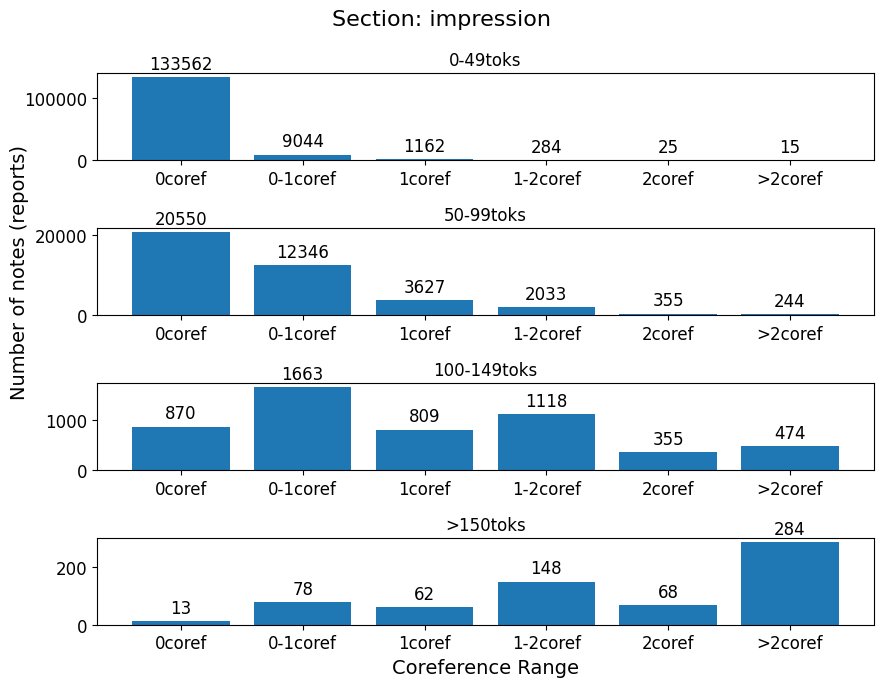

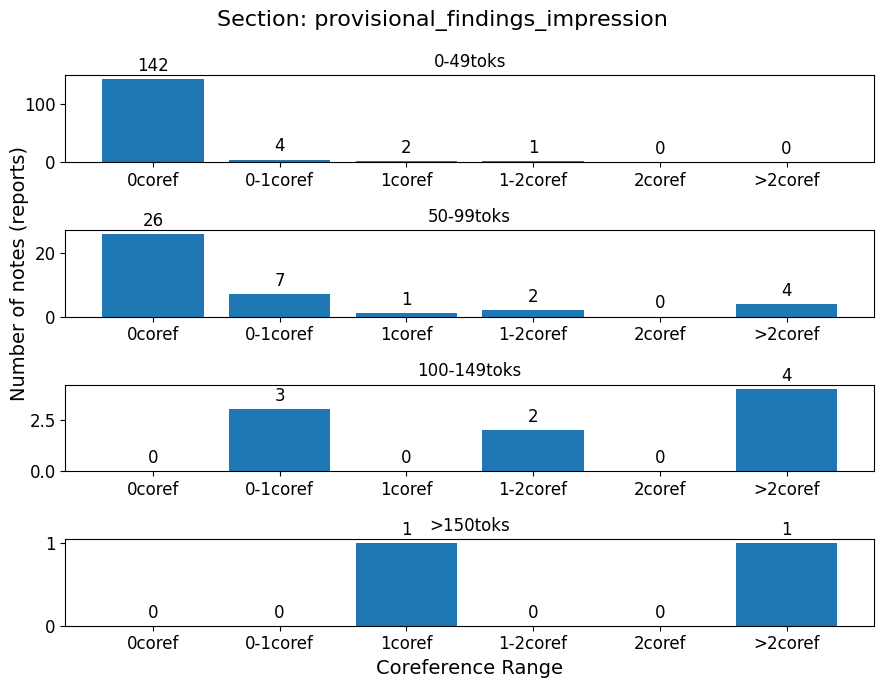

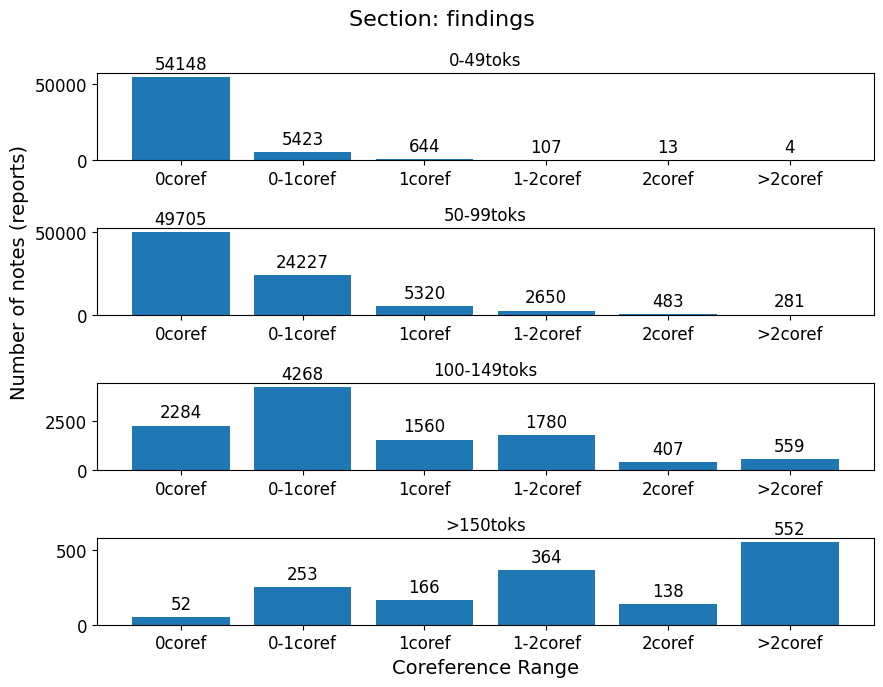

In [7]:
section_tokRange_corefRange_docList_dict:dict[str,dict] = {}
for section_name, doc_numData_dict in section_doc_numData_dict.items():
    section_tokRange_corefRange_docList_dict[section_name] = {
        "0-49toks": {
            "0coref":[], "0-1coref":[], "1coref":[], "1-2coref":[], "2coref":[], ">2coref":[]
        },
        "50-99toks": {
            "0coref":[], "0-1coref":[], "1coref":[], "1-2coref":[], "2coref":[], ">2coref":[]
        },
        "100-149toks": {
            "0coref":[], "0-1coref":[], "1coref":[], "1-2coref":[], "2coref":[], ">2coref":[]
        },
        ">150toks": {
            "0coref":[], "0-1coref":[], "1coref":[], "1-2coref":[], "2coref":[], ">2coref":[]
        },
    }
    tokRange_corefRange_docList_dict = section_tokRange_corefRange_docList_dict[section_name]
    for doc_id, numData_dict in doc_numData_dict.items():
        if 0 <= numData_dict["tokNum"] < 50:
            target_dict = tokRange_corefRange_docList_dict["0-49toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0coref"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1coref"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1coref"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2coref"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2coref"].append(doc_id)
            else:
                target_dict[">2coref"].append(doc_id)
        elif 50 <= numData_dict["tokNum"] < 99:
            target_dict = tokRange_corefRange_docList_dict["50-99toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0coref"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1coref"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1coref"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2coref"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2coref"].append(doc_id)
            else:
                target_dict[">2coref"].append(doc_id)
        elif 100 <= numData_dict["tokNum"] < 149:
            target_dict = tokRange_corefRange_docList_dict["100-149toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0coref"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1coref"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1coref"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2coref"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2coref"].append(doc_id)
            else:
                target_dict[">2coref"].append(doc_id)
        elif numData_dict["tokNum"] >= 150:
            target_dict = tokRange_corefRange_docList_dict[">150toks"]
            if numData_dict["avgNum"] == 0:
                target_dict["0coref"].append(doc_id)
            elif 0 < numData_dict["avgNum"] < 1:
                target_dict["0-1coref"].append(doc_id)
            elif numData_dict["avgNum"] == 1:
                target_dict["1coref"].append(doc_id)
            elif 1 < numData_dict["avgNum"] < 2:
                target_dict["1-2coref"].append(doc_id)
            elif numData_dict["avgNum"] == 2:
                target_dict["2coref"].append(doc_id)
            else:
                target_dict[">2coref"].append(doc_id)


    fig, axs = plt.subplots(4, 1, figsize=(9,7))
    fig.suptitle(f"Section: {section_name}")

    for ax_id, (tokRangeLabel, corefRangeDict) in enumerate(tokRange_corefRange_docList_dict.items()):
        x = corefRangeDict.keys()
        y = [len(_sid_list) for _sid_list in corefRangeDict.values()]
        bar_container = axs[ax_id].bar(x,y)
        axs[ax_id].set_title(tokRangeLabel)
        axs[ax_id].bar_label(bar_container, padding=3)

    axs[1].set_ylabel("Number of notes (reports)")
    axs[3].set_xlabel("Coreference Range")
    
    fig.tight_layout()


## Confusion Matrix

### Include 0 coref

Each value shown in a cell is percentage


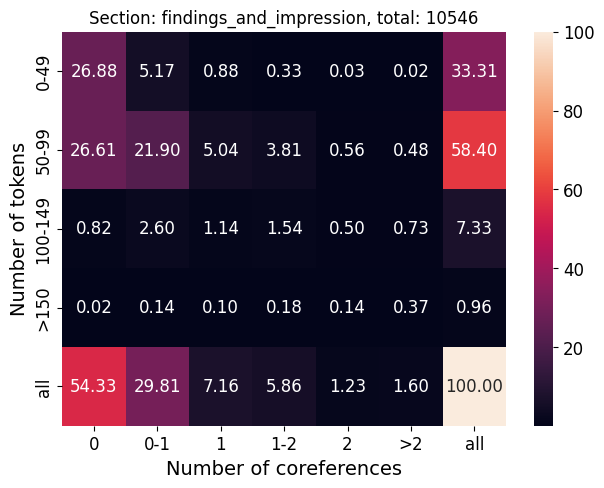

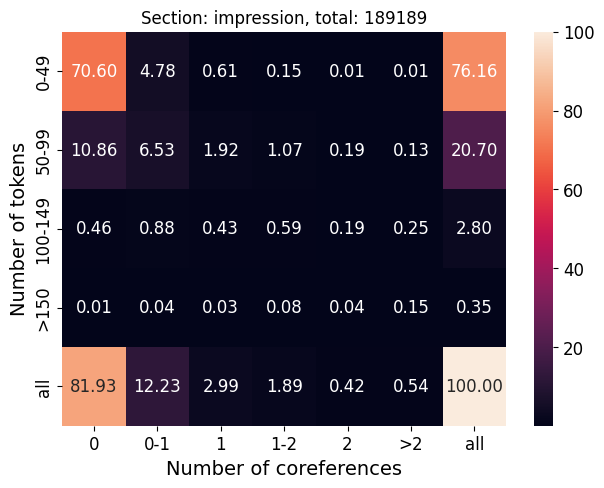

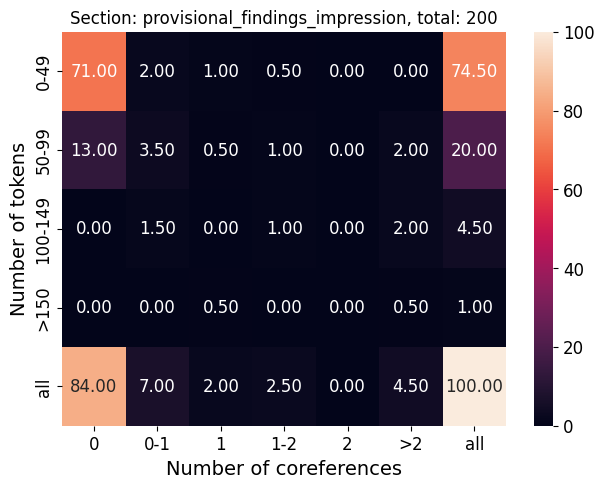

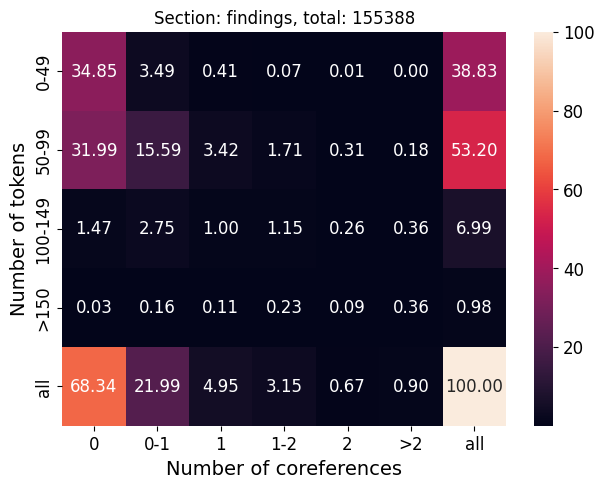

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for section_name, tokRange_corefRange_docList_dict in section_tokRange_corefRange_docList_dict.items():
    data_list:list[list] = []
    for tokRange, corefRange_docList_dict in tokRange_corefRange_docList_dict.items():
        data_row = []
        data_list.append(data_row)
        for corefRange, docList in corefRange_docList_dict.items():
            data_row.append(len(docList))
    data = np.array(data_list)
    percentages = data/data.sum() * 100

    new_row = []
    for col_idx in range(len(percentages[0])):
        new_row.append(percentages[:,col_idx].sum())
    new_percentages = np.append(percentages, [new_row], 0)

    new_col = []
    for row_idx in range(len(new_percentages)):
        new_col.append([new_percentages[row_idx].sum()])
    new_percentages = np.append(new_percentages, new_col, 1)

    x_labels = ["0", "0-1", "1", "1-2", "2", ">2", "all"]
    y_labels = ["0-49","50-99", "100-149", ">150", "all"]

    plt.figure() #this creates a new figure on which your plot will appear
    plt.title(f"Section: {section_name}, total: {data.sum()}")
    plt.tight_layout()

    ax = sns.heatmap(new_percentages, xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt='.2f')
    ax.set_xlabel("Number of coreferences")
    ax.set_ylabel("Number of tokens")

print("Each value shown in a cell is percentage")

### Exclude 0 coref

Each value shown in a cell is percentage


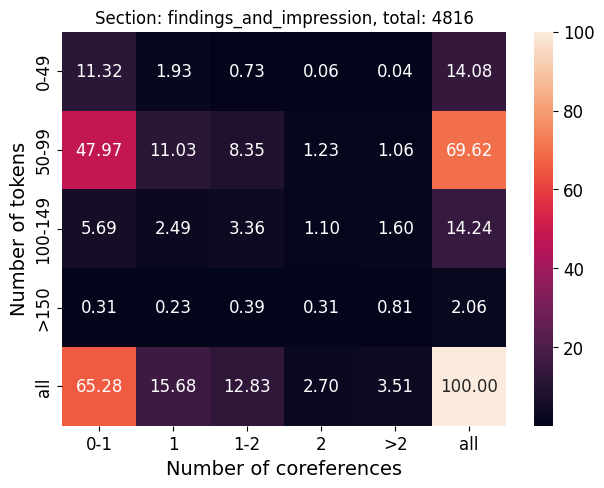

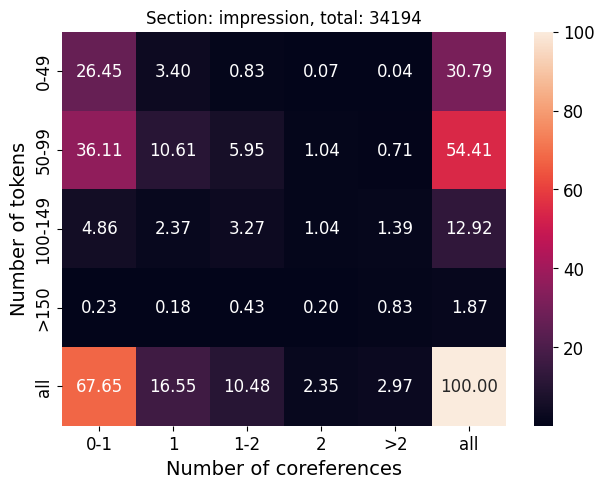

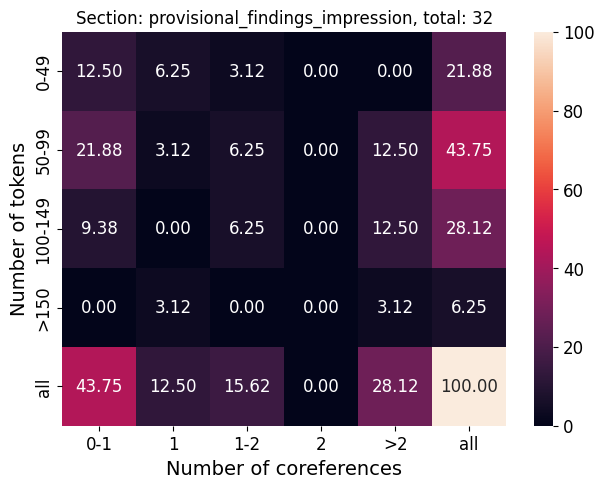

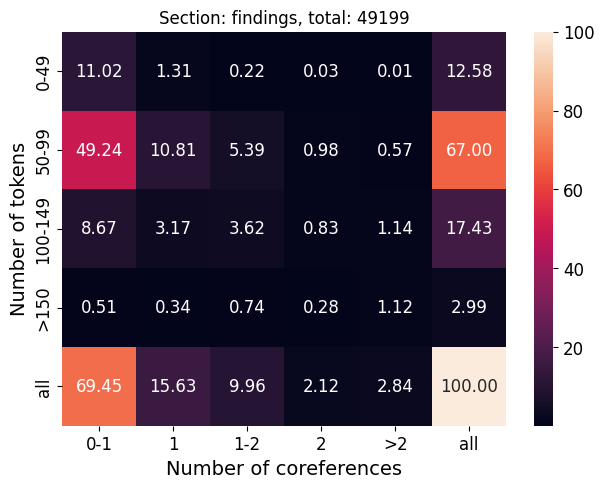

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

for section_name, tokRange_corefRange_docList_dict in section_tokRange_corefRange_docList_dict.items():
    data_list:list[list] = []
    for tokRange, corefRange_docList_dict in tokRange_corefRange_docList_dict.items():
        data_row = []
        data_list.append(data_row)
        for corefRange, docList in corefRange_docList_dict.items():
            if corefRange == "0coref":
                continue
            data_row.append(len(docList))
    data = np.array(data_list)
    percentages = data/data.sum() * 100

    # add overall statistic
    new_row = []
    for col_idx in range(len(percentages[0])):
        new_row.append(percentages[:,col_idx].sum())
    new_percentages = np.append(percentages, [new_row], 0)

    new_col = []
    for row_idx in range(len(new_percentages)):
        new_col.append([new_percentages[row_idx].sum()])
    new_percentages = np.append(new_percentages, new_col, 1)

    x_labels = ["0-1", "1", "1-2", "2", ">2", "all"]
    y_labels = ["0-49","50-99", "100-149", ">150", "all"]

    plt.figure() #this creates a new figure on which your plot will appear
    plt.title(f"Section: {section_name}, total: {data.sum()}")
    plt.tight_layout()

    ax = sns.heatmap(new_percentages, xticklabels=x_labels, yticklabels=y_labels, annot=True, fmt='.2f')
    ax.set_xlabel("Number of coreferences")
    ax.set_ylabel("Number of tokens")

print("Each value shown in a cell is percentage")

In [10]:
print(data)

new_row = []
for col_idx in range(len(data[0])):
    new_row.append(data[:,col_idx].sum())

new_data = np.append(data, [new_row], 0)


new_col = []
for row_idx in range(len(new_data)):
    new_col.append([new_data[row_idx].sum()])

new_data = np.append(new_data, new_col, 1)

print(new_data)


[[ 5423   644   107    13     4]
 [24227  5320  2650   483   281]
 [ 4268  1560  1780   407   559]
 [  253   166   364   138   552]]
[[ 5423   644   107    13     4  6191]
 [24227  5320  2650   483   281 32961]
 [ 4268  1560  1780   407   559  8574]
 [  253   166   364   138   552  1473]
 [34171  7690  4901  1041  1396 49199]]


## Sampling

### Example

In [11]:
doc_id = section_tokRange_corefRange_docList_dict["findings"]["100-149toks"]["1coref"][0]
section_name = "findings"
print("section_name, doc_id:",section_name, doc_id)

df_scoref = pd.read_csv(os.path.join(scoref_dir,section_name,f"{doc_id}.csv"), index_col=0, na_filter=False)
df_dcoref = pd.read_csv(os.path.join(dcoref_dir,section_name,f"{doc_id}.csv"), index_col=0, na_filter=False)
df_fcoref = pd.read_csv(os.path.join(fcoref_dir,section_name,f"{doc_id}.csv"), index_col=0, na_filter=False)


_, scoref_group_num = resolve_mention_and_group_num(df_scoref, "[co][ml]coref_group_conll")
_, dcoref_group_num = resolve_mention_and_group_num(df_dcoref, "[co][rb]coref_group_conll")
_, fcoref_group_num = resolve_mention_and_group_num(df_fcoref, "[fj]coref_group_conll")

print("scoref_group_num, dcoref_group_num, fcoref_group_num:", scoref_group_num, dcoref_group_num, fcoref_group_num)
print(section_list[0][1][sid_list.index(doc_id)])

section_name, doc_id: findings s54350689
scoref_group_num, dcoref_group_num, fcoref_group_num: 1 0 2
___.
PA and lateral views of the chest are compared to both prior chest x-ray from ___ and CT chest from ___. 
 Compared to prior exam, there has been no significant interval change in the widespread parenchymal opacities throughout the lung fields which are associated with overall volume loss.  There is no definite new region of consolidation nor pleural effusion.  Cardiac silhouette appears enlarged but could be accentuated due to lower lung volumes.  This is unchanged from prior. Osseous and soft tissue structures are unremarkable.


### Sample

In [12]:
import random
random.seed(42)

sampling_num_dict = {
    "findings": [
        [2,3,2,1,1,1],
        [7,5,5,4,1,1],
        [3,2,2,2,1,1],
        [1,1,1,1,1,1]
    ],
        "impression": [
        [4,3,2,1,1,1],
        [6,5,5,4,1,1],
        [2,2,2,2,1,1],
        [1,1,1,1,1,1]
    ]
}
output_section_doc_dict = {}
for section_name, tokRange_corefRange_docList_dict in section_tokRange_corefRange_docList_dict.items():
    if section_name not in sampling_num_dict:
        continue
    output_section_doc_dict[section_name] = []
    for x_idx,(tokRange, corefRange_docList_dict) in enumerate(tokRange_corefRange_docList_dict.items()):
        for y_idx, (corefRange, docList) in enumerate(corefRange_docList_dict.items()):
            docList = sorted(docList)
            required_num = sampling_num_dict[section_name][x_idx][y_idx]
            sampled_doc = [docList[random.randint(0,len(docList)-1)] for _ in range(required_num)]
            output_section_doc_dict[section_name].extend(sampled_doc)
            print(section_name, tokRange, corefRange, sampled_doc)

impression 0-49toks 0coref ['s52181400', 's50495534', 's55413865', 's54830797']
impression 0-49toks 0-1coref ['s54088920', 's52560967', 's51912229']
impression 0-49toks 1coref ['s59561237', 's51384527']
impression 0-49toks 1-2coref ['s57721486']
impression 0-49toks 2coref ['s50870177']
impression 0-49toks >2coref ['s50857443']
impression 50-99toks 0coref ['s51485705', 's53490136', 's53712847', 's58053419', 's59588224', 's50420639']
impression 50-99toks 0-1coref ['s57456995', 's52639006', 's59520223', 's58642308', 's59317535']
impression 50-99toks 1coref ['s56243300', 's54785672', 's52553303', 's55122346', 's56670734']
impression 50-99toks 1-2coref ['s52812639', 's58173343', 's58795811', 's50057221']
impression 50-99toks 2coref ['s52391473']
impression 50-99toks >2coref ['s56799694']
impression 100-149toks 0coref ['s54745658', 's53752672']
impression 100-149toks 0-1coref ['s53383593', 's52015567']
impression 100-149toks 1coref ['s52484542', 's59586953']
impression 100-149toks 1-2coref [

In [13]:
print(output_section_doc_dict)

{'impression': ['s52181400', 's50495534', 's55413865', 's54830797', 's54088920', 's52560967', 's51912229', 's59561237', 's51384527', 's57721486', 's50870177', 's50857443', 's51485705', 's53490136', 's53712847', 's58053419', 's59588224', 's50420639', 's57456995', 's52639006', 's59520223', 's58642308', 's59317535', 's56243300', 's54785672', 's52553303', 's55122346', 's56670734', 's52812639', 's58173343', 's58795811', 's50057221', 's52391473', 's56799694', 's54745658', 's53752672', 's53383593', 's52015567', 's52484542', 's59586953', 's56281186', 's51716783', 's51360591', 's54169498', 's51926077', 's56045175', 's58655459', 's55636914', 's54623295', 's51246808'], 'findings': ['s58845775', 's55582558', 's58197956', 's51888715', 's55764799', 's51217938', 's58961856', 's53729437', 's55180638', 's54747237', 's57587299', 's52533060', 's59278589', 's50937604', 's50628754', 's58699425', 's53000242', 's53916349', 's51073398', 's53132887', 's51351983', 's55138068', 's54284884', 's56981342', 's597943

### Generate txt

In [295]:
from tqdm import tqdm
from common_utils.common_utils import check_and_remove_dirs

check_and_remove_dirs("../../output/mimic_cxr/statistic/for_brat_annotation", True)
for section_name, _doc_list in output_section_doc_dict.items():
    output_dir = os.path.join("../../output/mimic_cxr/statistic/for_brat_annotation",section_name)
    check_and_create_dirs(output_dir)
    input_dir = os.path.join("../../output/mimic_cxr/nlp_ensemble/spacy",section_name)
    for doc_id in tqdm(_doc_list):
        df_spacy = pd.read_csv(os.path.join(input_dir, f"{doc_id}.csv"), index_col=0, na_filter=False)
        df_sentence = df_spacy.groupby(['[sp]sentence_group'])['[sp]token'].apply(' '.join).reset_index()
        sentences = [str(_series.get("[sp]token")).strip() for _, _series in df_sentence.iterrows()]
        with open(os.path.join(output_dir, f"{doc_id}.txt"), "w", encoding="UTF-8") as f:
            f.write("\n".join(sentences))

100%|██████████| 50/50 [00:00<00:00, 497.64it/s]

findings s55710400 ['Compare with _ _ _ at 11:18 ( earlier the same day ) , there has been interval improvement in the appearance of the right lung .', 'The area of dense thickening seen along the expected course of the minor fissure is significantly improved , though it remains partially visible , suggesting interval re - expansion of portions of the right lung .', '', 'Patchy opacity however remains visible in the aerated portions of the right lung .', 'The right hemidiaphragm remains elevated , with blunting of the right costophrenic angle , and a small amount of pleural thickening along the right chest wall on the lung apex .', 'The right paratracheal soft tissue density remains thickened .', '', 'As before , the cardiomediastinal silhouette remains midline and appears overall unchanged .', 'The right hilum , as before , is obscured by surrounding opacities .', '', 'Also , as before , left lung remains grossly clear , without CHF focal consolidation or effusion .', 'Minimal atelect

## Test

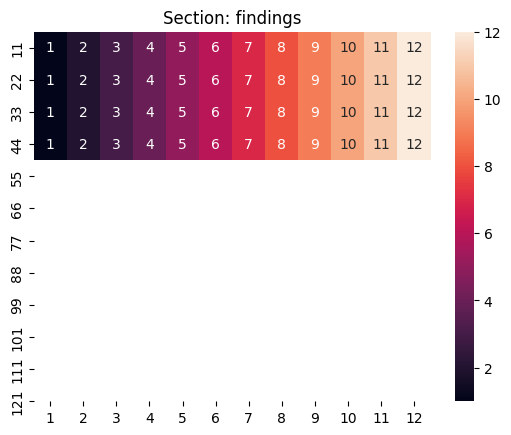

In [188]:


plt.figure() #this creates a new figure on which your plot will appear
plt.title(f"Section: {section_name}")
plt.xlabel('Coref num') # x-axis label with fontsize 15
plt.ylabel('Token num') # y-axis label with fontsize 15

data = np.array([[1,2,3,4,5,6,7,8,9,10,11,12],[1,2,3,4,5,6,7,8,9,10,11,12],[1,2,3,4,5,6,7,8,9,10,11,12],[1,2,3,4,5,6,7,8,9,10,11,12]])
x_axis_labels = [1,2,3,4,5,6,7,8,9,10,11,12] # labels for x-axis
y_axis_labels = [11,22,33,44,55,66,77,88,99,101,111,121] # labels for y-axis

ax = sns.heatmap(data,xticklabels=x_axis_labels, yticklabels=y_axis_labels,annot=True)

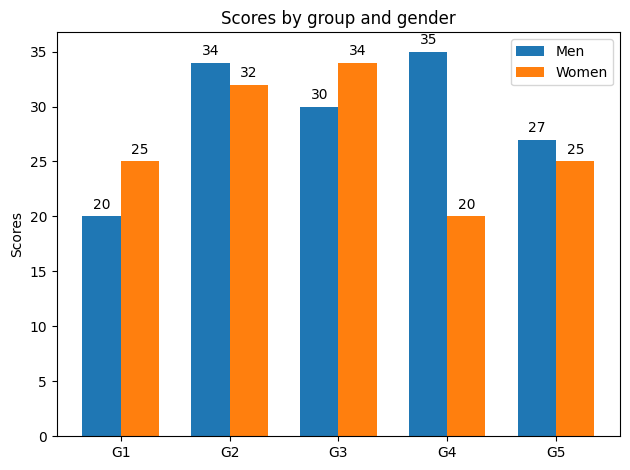

In [189]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [256]:
import pandas as pd
from io import StringIO

data = StringIO("""
"name1","hej","2014-11-01"
"name1","du","2014-11-02"
"name1","aj","2014-12-01"
"name1","oj","2014-12-02"
"name2","fin","2014-11-01"
"name2","katt","2014-11-02"
"name2","mycket","2014-12-01"
"name2","lite","2014-12-01"
""")

# load string as stream into dataframe
df = pd.read_csv(data,header=0, names=["name","text","date"],parse_dates=[2])
df["month"] = df["date"].apply(lambda x: x.month)
df.groupby(['name','month'])['text'].apply(','.join).reset_index()